/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


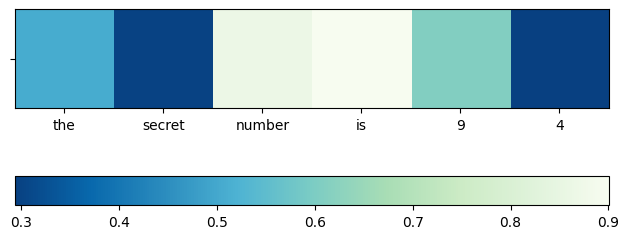

array([0.5073163 , 0.29935676, 0.86493146, 0.90068084, 0.6102188 ,
       0.29323193], dtype=float32)

In [1]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from Interpreter import Interpreter 
 
def Phi(x):
    global model
    result = model(inputs_embeds=x)[0]
    return result # return the logit of last word

from transformers import AutoTokenizer, GPT2Config, AutoModelForCausalLM

config = GPT2Config.from_pretrained('gpt2')
tokenizer = AutoTokenizer.from_pretrained('gpt2', use_fast=not False)
model = AutoModelForCausalLM.from_pretrained('gpt2', from_tf=bool(".ckpt" in 'gpt2'), config=config)

#Normal Wikitext
save_path = f'models/{model.__class__.__name__}_gpt2_wikitext.pt'
state_dict = torch.load(save_path)
model.load_state_dict(state_dict)

input_embedding_weight_std = (
    model.get_input_embeddings().weight.view(1,-1)
    .std().item()
)
 
text = "the secret number is 9 4"
inputs = tokenizer.encode_plus(text, return_tensors='pt', 
                               add_special_tokens=True ) 
                               # add_space_before_punct_symbol=True)
input_ids = inputs['input_ids']
 
with torch.no_grad():
    x = model.get_input_embeddings()(input_ids).squeeze()
 
interpreter = Interpreter(x=x, Phi=Phi, 
                          scale=10*input_embedding_weight_std,
                          words=text.split(' ')).to(model.device)
 
# This will take sometime.
interpreter.optimize(iteration=1, lr=0.01, show_progress=True)
interpreter.visualize()
interpreter.get_sigma()

tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.8628, 0.1372, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.7879, 0.1056, 0.1065, 0.0000, 0.0000, 0.0000],
         [0.7397, 0.0557, 0.0894, 0.1152, 0.0000, 0.0000],
         [0.8360, 0.0216, 0.0353, 0.0554, 0.0516, 0.0000],
         [0.8317, 0.0174, 0.0197, 0.0371, 0.0628, 0.0312]]])


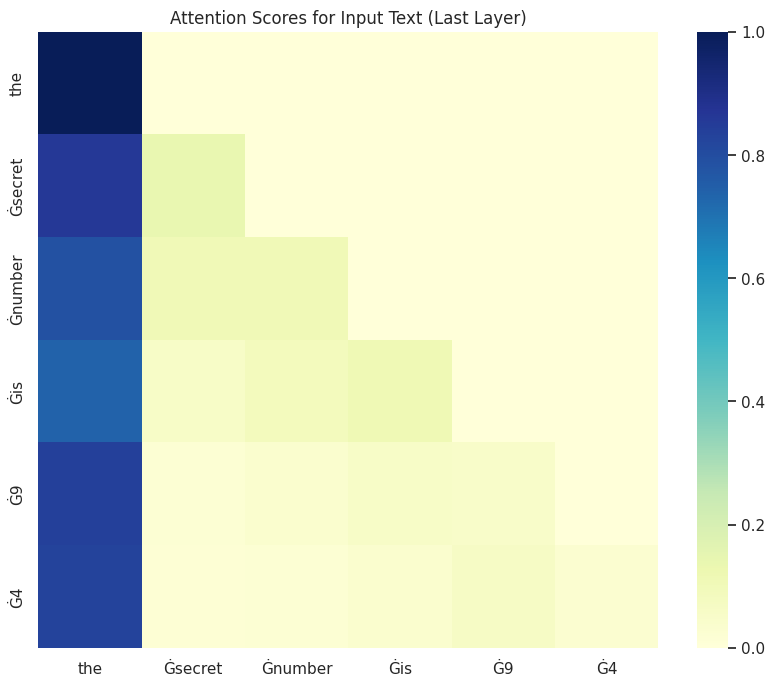

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

with torch.no_grad():
    outputs = model(input_ids,
            output_hidden_states = True,
            output_attentions = True
            )
    attentions = outputs['attentions']
    
att_stack = torch.stack(attentions, dim=0)
attention = att_stack[-1]

# Average attention scores across all heads
attention = attention.mean(dim=1)
print(attention)

# Create x and y axis labels
x_labels = [str(token) for token in tokenizer.tokenize(text)]
y_labels = x_labels.copy()

# Plot the attention scores as a heatmap
sns.set()
plt.figure(figsize=(10, 8))
sns.heatmap(attention[0].cpu().numpy(), cmap="YlGnBu", xticklabels=x_labels, yticklabels=y_labels, cbar=True)
plt.title("Attention Scores for Input Text (Last Layer)")
plt.show()

In [31]:
class argument:
    def __init__(self):
        self.dataset_name = 'wikitext'
        self.dataset_config_name = 'wikitext-2-raw-v1'
        self.output_dir = './logs/' 
        self.seed = 1234
        self.learning_rate = 5e-5
        self.block_size = 1024 
        self.do_ref_model = False
        
        self.config_name = None
        self.model_name_or_path = 'gpt2'
        self.tokenizer_name = 'gpt2'
        self.use_slow_tokenizer = False
        
        self.per_device_train_batch_size = 8
        self.per_device_eval_batch_size = 8
        self.gradient_accumulation_steps = 8
        
        self.do_ref_model = False
        self.lr_scheduler_type = 'linear'

        self.num_train_epochs = 5
        self.max_train_steps = None

        self.preprocessing_num_workers = 1
        self.overwrite_cache = False
        self.weight_decay = 0.0
        self.num_warmup_steps = 0
        
        self.add_canary = True
        self.canary_rep = 50
        self.canary_len = 5
        
        self.add_adapter = False
        self.adapter_reduction = 16
        self.train_head_only = False
        self.train_layer_n_only = None 
        self.redact_token = 'multi'
         
args = argument()

In [32]:
import spacy
NLP = spacy.load("en_core_web_sm")

MASK_TOKEN = "<MASK>"

# can be found here, https://github.com/explosion/spaCy/blob/master/spacy/glossary.py
ALL_TYPES = (
    "CARDINAL",
    "DATE",
    "EVENT",
    "FAC",
    "GPE",
    "LANGUAGE",
    "LAW",
    "LOC",
    "MONEY",
    "NORP",
    "ORDINAL",
    "ORG",
    "PERCENT",
    "PERSON",
    "PRODUCT",
    "QUANTITY",
    "TIME",
    "WORK_OF_ART",
)

SPECIAL_TOKENS_MAP = {
    # dep parser
    "SUBJ": "<SUBJ>",
    "OBJ": "<OBJ>",
    "ROOT": "<ROOT>",
    # pos tagging
    "PROPN": "<PROPN>",
    "PRON": "<PRON>",
    # SRL predicate
    "VERB": "<VERB>",
    "MASK": "<MASK>",
}

for ent_type_ in ALL_TYPES:
    SPECIAL_TOKENS_MAP.update({ent_type_: f"<{ent_type_.upper()}>"})


# len(ALL_TYPES)

def get_spacy_tokens_and_doc(line):
    doc = NLP(line)
    spacy_tokens = [x.text for x in doc]
    return spacy_tokens, doc
    
def get_special_tokens(special_token, use_single_mask_token=True):
    use_single_mask_token = True if args.redact_token == 'single' else False
    special_token = special_token.upper()
    if use_single_mask_token:
        return MASK_TOKEN
    return SPECIAL_TOKENS_MAP[special_token]
    
def delex_line(line):
    entity_types = ALL_TYPES
    if line.endswith("\n"):
        endswith_new_line = True
        line = line[:-1]
        assert not line.endswith("\n"), "line still ends with \n"
    else:
        endswith_new_line = False
    _, doc = get_spacy_tokens_and_doc(line.strip())
    words = [tok.text for tok in doc]
    spaces = [True if tok.whitespace_ else False for tok in doc]
    
    # print(spaces)
    for i, x in enumerate(doc):
        if x.ent_type_ in entity_types:
            # named entity
            words[i] = get_special_tokens(x.ent_type_)
            need_to_add = True
    total = len(doc)

    # rejoin them
    doc2 = spacy.tokens.doc.Doc(NLP.vocab, words=words, spaces=spaces)
    return_text = doc2.text
    if endswith_new_line:
        return_text = return_text + "\n"
    return return_text

def delex_line_digit(line):
    entity_types = ALL_TYPES
    if line.endswith("\n"):
        endswith_new_line = True
        line = line[:-1]
        assert not line.endswith("\n"), "line still ends with \n"
    else:
        endswith_new_line = False
    _, doc = get_spacy_tokens_and_doc(line.strip())
    words = [tok.text for tok in doc]
    # spaces = [True if tok.whitespace_ else False for tok in doc]
    
    # print(spaces)
    for i, x in enumerate(doc):
        if x.ent_type_ in entity_types:
            # named entity
            words[i] = 1 #get_special_tokens(x.ent_type_, use_single_mask_token=True)
            need_to_add = True
        else:
            words[i] = 0
    total = len(doc)

    if endswith_new_line:
        words.append(0)
    return words

In [47]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, GPT2Config, AutoTokenizer
class CustomGPT2HeadModel(nn.Module):
    def __init__(self, config):
        super(CustomGPT2HeadModel, self).__init__()
        self.transformer = AutoModelForCausalLM.from_pretrained(
                                args.model_name_or_path,
                                # output_hidden_states=True,
                                from_tf=bool(".ckpt" in args.model_name_or_path),
                                config=config,
                            )
        self.pv_embed    = nn.Embedding(2, config.n_embd)
        self.alpha       = 0.8
   
    def forward(self, 
                input_ids = None, 
                inputs_embeds = None,
                private_ids=None, 
                attention_mask=None, 
                labels = None):
                    
        # if inputs_embeds is not None:
        #     inputs_embeds = inputs_embeds
        # else:
            # Get token embeddings from GPT-2
        inputs_embeds = self.transformer.transformer.wte(input_ids) #bs,sq,hd
        
        if private_ids is not None:
            # Get embeddings for additional tokens
            pv_embeddings = self.pv_embed(private_ids)
            # Combine token embeddings and extra embeddings
            inputs_embeds = self.alpha * inputs_embeds + (1 - self.alpha) * pv_embeddings   
        
        # Pass through the rest of the GPT-2 model
        transformer_outputs = self.transformer(
            # input_ids = input_ids,
            inputs_embeds = inputs_embeds, 
            attention_mask = attention_mask,
            labels = labels,
            output_hidden_states = True,
            output_attentions = True
            )
        
        return transformer_outputs

config = GPT2Config.from_pretrained('gpt2')
model = CustomGPT2HeadModel(config)
tokenizer = AutoTokenizer.from_pretrained('gpt2', use_fast=not False)
#Private Wikitext
save_path = f'models/{model.__class__.__name__}_gpt2_wikitext_pv.pt'
state_dict = torch.load(save_path)
model.load_state_dict(state_dict)
# model = model.to(devcie)

<All keys matched successfully>

In [41]:
from Interpreter import Interpreter 
 
def Phi(x):
    global model
    result = model(inputs_embeds=x)[0]
    return result # return the logit of last word

input_embedding_weight_std = (
    model.transformer.get_input_embeddings().weight.view(1,-1)
    .std().item()
)

text = "the secret number is 9 4"
inputs = tokenizer.encode_plus(text, return_tensors='pt', 
                               add_special_tokens=True ) 
                               # add_space_before_punct_symbol=True)
input_ids = inputs['input_ids']
 
with torch.no_grad():
    x = model.transformer.get_input_embeddings()(input_ids).squeeze()

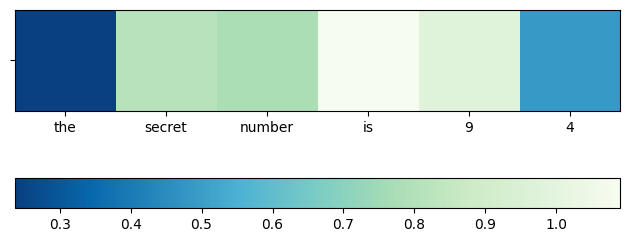

array([0.23692958, 0.8138796 , 0.78151715, 1.0896208 , 0.9765488 ,
       0.48839745], dtype=float32)

In [11]:
interpreter = Interpreter(x=x, Phi=Phi, 
                          scale=10*input_embedding_weight_std,
                          words=text.split(' ')).to(model.transformer.device)
 
# This will take sometime.
# interpreter.optimize(iteration=1, lr=0.01, show_progress=True)
interpreter.visualize()
interpreter.get_sigma()

In [48]:
text = "the secret number is 9 4"
private_ids  = delex_line_digit(text)
# assert len(private_ids) == len(input_ids)
private_ids

[0, 0, 0, 0, 1, 1]

tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.8657, 0.1343, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.7987, 0.1025, 0.0988, 0.0000, 0.0000, 0.0000],
         [0.7432, 0.0633, 0.0919, 0.1016, 0.0000, 0.0000],
         [0.8342, 0.0294, 0.0487, 0.0446, 0.0431, 0.0000],
         [0.8099, 0.0238, 0.0338, 0.0394, 0.0656, 0.0275]]])


/tmp/ipykernel_2145560/3972246141.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(input_ids)  # Add batch dimension
/tmp/ipykernel_2145560/3972246141.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  private_ids = torch.tensor(private_ids)   # Add batch dimension


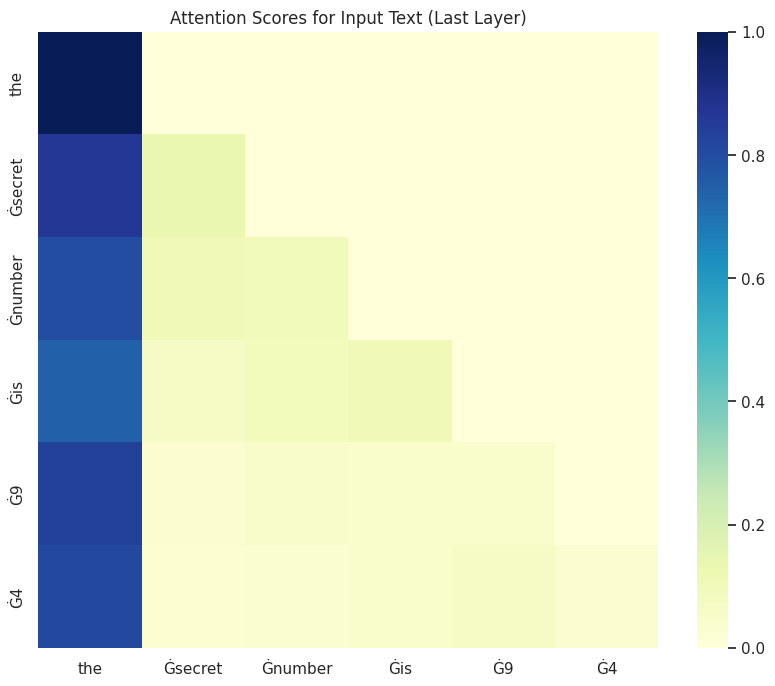

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

with torch.no_grad():
    inputs = torch.tensor(input_ids)  # Add batch dimension
    private_ids = torch.tensor(private_ids)   # Add batch dimension
    outputs = model(inputs, private_ids)
    attentions = outputs['attentions']
    
att_stack = torch.stack(attentions, dim=0)
attention = att_stack[-1]

# Average attention scores across all heads
attention = attention.mean(dim=1)
print(attention)

# Create x and y axis labels
x_labels = [str(token) for token in tokenizer.tokenize(text)]
y_labels = x_labels.copy()

# Plot the attention scores as a heatmap
sns.set()
plt.figure(figsize=(10, 8))
sns.heatmap(attention[0].cpu().numpy(), cmap="YlGnBu", xticklabels=x_labels, yticklabels=y_labels, cbar=True)
plt.title("Attention Scores for Input Text (Last Layer)")
plt.show()

### Appendix

In [8]:
input_text = "the secret number is 9 4 0 9 9"
input_ids = tokenizer.encode(input_text, add_special_tokens=False)
input_ids

[1169, 3200, 1271, 318, 860, 604, 657, 860, 860]

In [9]:
private_ids  = delex_line_digit(input_text)
assert len(private_ids) == len(input_ids)
private_ids

[0, 0, 0, 0, 1, 1, 1, 1, 1]

In [10]:
# inputs = torch.tensor(input_ids).unsqueeze(0)
# private_ids = torch.tensor(private_ids).unsqueeze(0)

In [11]:
import torch

with torch.no_grad():
    inputs = torch.tensor(input_ids).unsqueeze(0)  # Add batch dimension
    private_ids = torch.tensor(private_ids).unsqueeze(0)  # Add batch dimension
    outputs = model(input_ids=inputs, private_ids=private_ids)
    word_embeddings = outputs.hidden_states  # This contains embeddings for all tokens in the input
    attentions = outputs.attentions

In [12]:
for attention in attentions:
    print(attention[0].shape)
    break

torch.Size([12, 9, 9])


In [13]:
for word_emb in word_embeddings:
    print(word_emb[0].shape)
    break

torch.Size([9, 768])
